In [60]:
import sys
sys.path.append('..')
from src.models.pipeline import pipeline
import glob
import json
import os
import pandas as pd
import ast
from datetime import datetime
from src.models.train_model import functionsBuilder
from src.models.audio import downloadAudioFromYoutube
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from src.data import pdf
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from src.visualization.visualize import MyPlotting
from gensim import similarities
import re

In [2]:
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''

def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec


for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])

In [3]:
'''From the get optimized by bayesian we get that for the video '''
# the precision is about 66% 
vid = 'dkAr9ThdSUU'
params = {'n_clusters': 18, 'sim_thresh': 0.6, 'step_size': 49, 'window_size': 150}
workflow = 'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering'

groundbase = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()[:-1]
transcripts = transcripts_jsons[vid]
#print(grounbase)

In [4]:
'''This running may not work at first time do not give up and run it couple of times'''

shift_times,topic_words = pipeline.run_for_baye(groundbase,transcripts,slicing_method='sliding_window',
                      window_size=params['window_size'],step_size_sd=params['step_size'],
                      #silence_threshold=-30,slice_length=1000,step_size_audio=10,wav_file_path="../../data/raw/audio/Mod-01 Lec-01 Foundation of Scientific Computing-01.wav",                
                      vector_method='tfidf',vectorizing_params=None,
                      similarity_method='cosine',
                      filter_params={"filter_type":'median',
                                     "mask_shape":(3,3),
                                     "sim_thresh":params['sim_thresh'],
                                     "is_min_thresh":True
                                     },
                     clustering_params={
                             'algorithm':'spectral_clustering',
                             'n_clusters':params['n_clusters']
                             },return_value='division')

In [5]:
len(shift_times)

15

In [61]:
[len(tp) for tp in topic_words]

[151, 141, 104, 295, 342, 194, 198, 198, 83, 155, 129, 102, 143, 113, 90, 185]

In [8]:
for tp_i,tp_words in enumerate(topic_words):
    print('Finding top words for topic %s' %(tp_i))
    raw_text = ' '.join(tp_words)
    myvectorizer = CountVectorizer()
    mytf = myvectorizer.fit_transform([raw_text]).toarray()
    #print(mytf)
    maxes = heapq.nlargest(4,mytf[0])
    indexes = []
    for i,bal in enumerate(mytf[0]):
        if bal in maxes:
            indexes.append(i)
    [ print(myvectorizer.get_feature_names()[_]) for i,_ in enumerate(indexes)]

Finding top words for topic 0
information
question
random
try
Finding top words for topic 1
cipher
encrypt
guess
information
Finding top words for topic 2
attacker
computation
notion
security
today
try
unbounded
Finding top words for topic 3
head
point
problem
tail
Finding top words for topic 4
event
number
probability
time
Finding top words for topic 5
probability
random
value
variable
Finding top words for topic 6
number
probability
random
success
variable
Finding top words for topic 7
attack
experiment
number
occur
power
time
Finding top words for topic 8
experiment
get
power
sigma
time
work
Finding top words for topic 9
collision
consider
least
probability
student
Finding top words for topic 10
bear
collision
person
power
probability
product
Finding top words for topic 11
equal
find
people
power
probability
Finding top words for topic 12
birthday
collision
cycle
find
keep
list
point
power
Finding top words for topic 13
complexity
cycle
equal
space
tree
Finding top words for topic 1

In [9]:
df

In [10]:
pdf_name = 'deeplearningbook-prob.pdf'
path = '../data/raw/pdf/' + vid +'/' +pdf_name

pdf_raw_text = pdf.read_pdf_raw(path)

In [22]:
chapter_titles,start_end_indexes = pdf.get_chapters_titles(pdf_raw_text)
chapters_content = pdf.get_chapters_content(pdf_raw_text,start_end_indexes)

In [12]:
chapter_titles

[' Why Probability?',
 ' Random Variables',
 ' Probability Distributions',
 ' Discrete Variables and Probability Mass Functions',
 ' Continuous Variables and Probability Density Functions',
 ' Marginal Probability',
 ' Conditional Probability',
 ' The Chain Rule of Conditional Probabilities',
 ' Independence and Conditional Independence',
 ' Common Probability Distributions',
 ' Bernoulli Distribution',
 ' Multinoulli Distribution',
 ' Gaussian Distribution',
 ' Exponential and Laplace Distributions',
 ' The Dirac Distribution and Empirical Distribution',
 ' Mixtures of Distributions',
 ' Useful Properties of Common Functions',
 ' Technical Details of Continuous Variables',
 ' Information Theory',
 ' Structured Probabilistic Models']

In [23]:
chapters_content[0]

[['many',
  'branch',
  'computer',
  'science',
  'deal',
  'entity',
  'deterministic',
  'certain'],
 ['assume', 'execute', 'machine', 'instruction'],
 ['error',
  'hardware',
  'occur',
  'rare',
  'enough',
  'software',
  'application',
  'need',
  'design',
  'account'],
 ['give',
  'many',
  'computer',
  'scientist',
  'software',
  'engineer',
  'work',
  'clean',
  'certain',
  'environment',
  'surprising',
  'machine',
  'learning',
  'make',
  'heavy',
  'use',
  'probability',
  'theory'],
 ['machine',
  'must',
  'deal',
  'uncertain',
  'quantity',
  'may',
  'need',
  'deal',
  'stochastic',
  'non',
  'deterministic',
  'quantity'],
 ['uncertainty', 'stochasticity', 'arise', 'many', 'source'],
 ['researcher',
  'make',
  'compelling',
  'argument',
  'quantify',
  'uncertainty',
  'use',
  'probability',
  'least'],
 ['many', 'argument', 'present', 'summarize', 'inspired', 'pearl'],
 ['activity', 'require', 'ability', 'reason', 'presence', 'uncertainty'],
 ['fact',
 

In [19]:
topic_words[0]

['today',
 'class',
 'probability',
 'information',
 'theory',
 'important',
 'study',
 'huge',
 'field',
 'today',
 'shall',
 'try',
 'concentrate',
 'basic',
 'principle',
 'necessary',
 'understand',
 'design',
 'analysis',
 'cipher',
 'today',
 'talk',
 'shall',
 'talk',
 'importance',
 'probability',
 'cryptography',
 'discuss',
 'computational',
 'security',
 'follow',
 'discussion',
 'distribution',
 'application',
 'important',
 'birthday',
 'paradox',
 'conclude',
 'concept',
 'entropy',
 'information',
 'theory',
 'discuss',
 'remember',
 'first',
 'class',
 'try',
 'answer',
 'question',
 'nature',
 'probable',
 'insecure',
 'event',
 'remember',
 'example',
 'coin',
 'flip',
 'telephone',
 'question',
 'probability',
 'create',
 'equal',
 'remember',
 'question',
 'alice',
 'able',
 'choose',
 'different',
 'value',
 'outcome',
 'denote',
 'question',
 'try',
 'address',
 'important',
 'information',
 'question',
 'value',
 'able',
 'extract',
 'information',
 'parity',
 't

In [36]:
# let's create a dictionary of the whole of the words in the paper and the video

# adding the video words
raw_text_all = []
for tp_vid in topic_words:
    raw_text_all = raw_text_all + tp_vid
    
len(raw_text_all)    
    
paper_chapters_one_doc = []
for index,chapter in enumerate(chapters_content):
    x = reduce(lambda x,y: x+y,chapter,[])
    paper_chapters_one_doc.append(x)
    raw_text_all = raw_text_all + x
len(raw_text_all)    

#raw_text_all
# creating dictionary of all of the words in the corpus of the video and the paper
dictionary = Dictionary([raw_text_all])
#dictionary.doc2bow(raw_text_all[0:30])

In [44]:
whole_corpus = topic_words + paper_chapters_one_doc
print(len(paper_chapters_one_doc))
print(len(topic_words))
print(len(whole_corpus))

"""maybe think in the future to apply different model 
rather than tfidf or calculate the document differntly"""
#print(whole_corpus)
bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
tf_idf_model = models.TfidfModel(bgw_corpus)
#print(tf_idf_model[bgw_corpus[0]])
bgw_chapter = [dictionary.doc2bow(doc) for doc in paper_chapters_one_doc]
index_sim = similarities.SparseMatrixSimilarity(tf_idf_model[bgw_chapter],
                                                num_features=len(dictionary))
bgw_vids = [dictionary.doc2bow(doc) for doc in topic_words]
correlation = [[s for s in index_sim[tf_idf_model[doc]]] for doc in bgw_vids]
MyPlotting.similarity_matrix(correlation)
for i,corr in enumerate(correlation):
    max_cor = max(corr)
    print ("For topic %s the most correlated chapter is %s with correlatoin ratio %s" 
           %(i+1,chapter_titles[corr.index(max_cor)],max_cor))

20
16
36


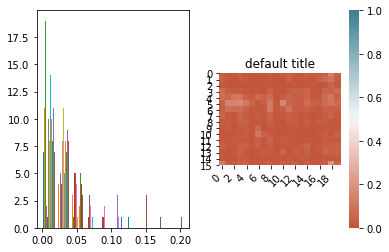

For topic 1 the most correlated chapter is  Information Theory with correlatoin ratio 0.1397547
For topic 2 the most correlated chapter is  Information Theory with correlatoin ratio 0.10312224
For topic 3 the most correlated chapter is  Information Theory with correlatoin ratio 0.048375133
For topic 4 the most correlated chapter is  Structured Probabilistic Models with correlatoin ratio 0.084179744
For topic 5 the most correlated chapter is  Information Theory with correlatoin ratio 0.11074835
For topic 6 the most correlated chapter is  Discrete Variables and Probability Mass Functions with correlatoin ratio 0.16641639
For topic 7 the most correlated chapter is  Independence and Conditional Independence with correlatoin ratio 0.12060974
For topic 8 the most correlated chapter is  Why Probability? with correlatoin ratio 0.057244457
For topic 9 the most correlated chapter is  Continuous Variables and Probability Density Functions with correlatoin ratio 0.04371377
For topic 10 the most co